## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset


## Basic EDA

In [2]:
data = pd.read_csv('../.data/boston.csv').drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [5]:
data.isnull().mean()

crim       0.0
zn         0.0
indus      0.0
chas       0.0
nox        0.0
rm         0.0
age        0.0
dis        0.0
rad        0.0
tax        0.0
ptratio    0.0
black      0.0
lstat      0.0
medv       0.0
dtype: float64

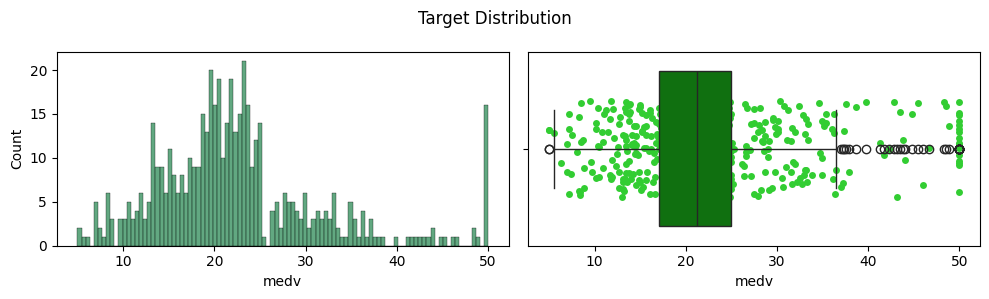

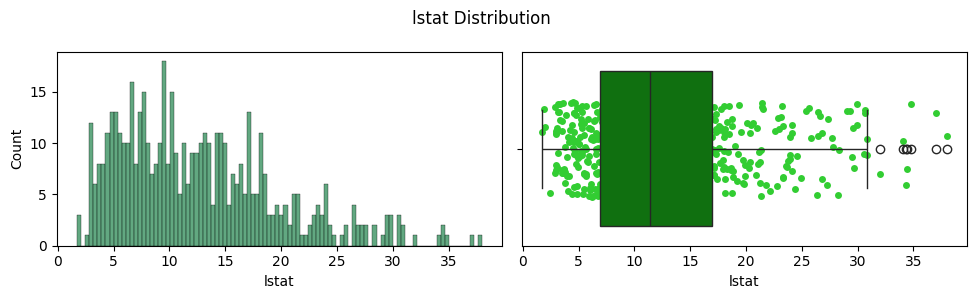

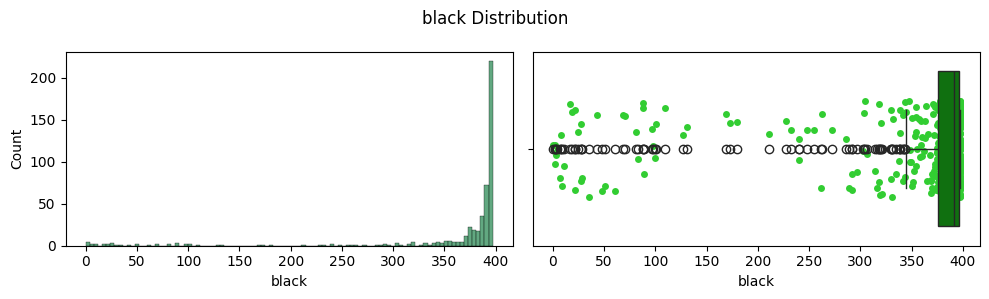

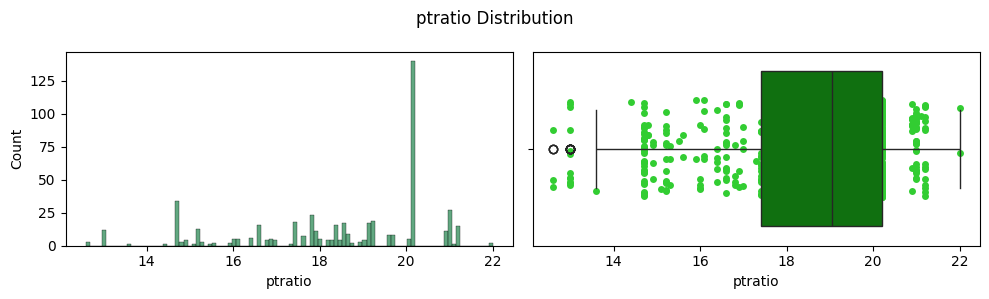

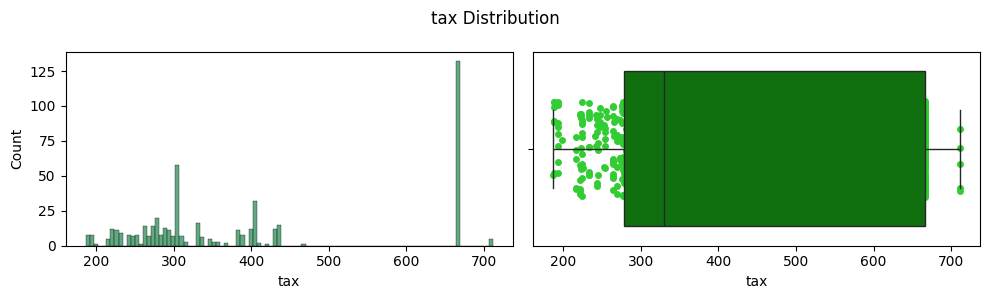

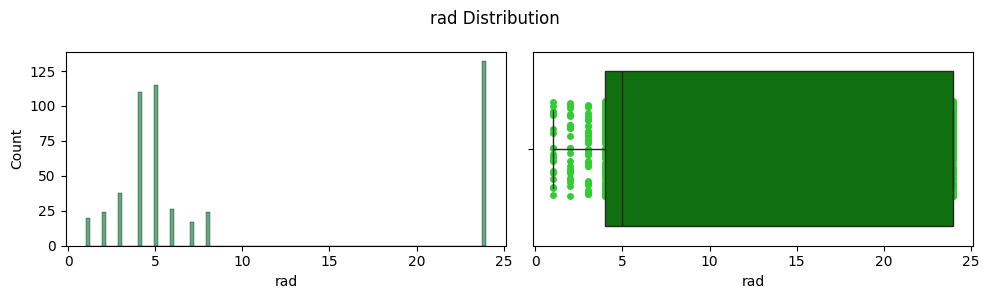

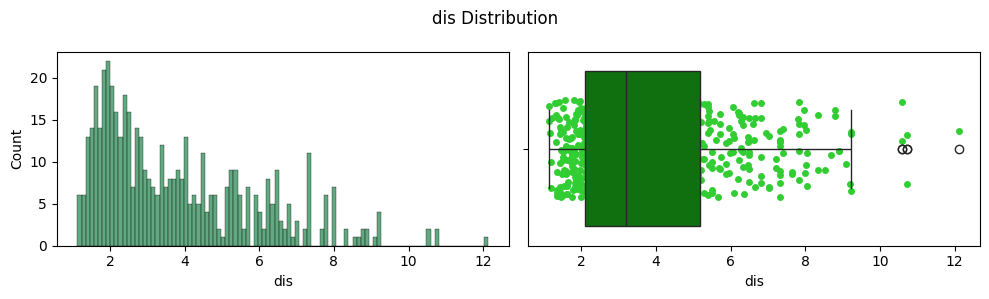

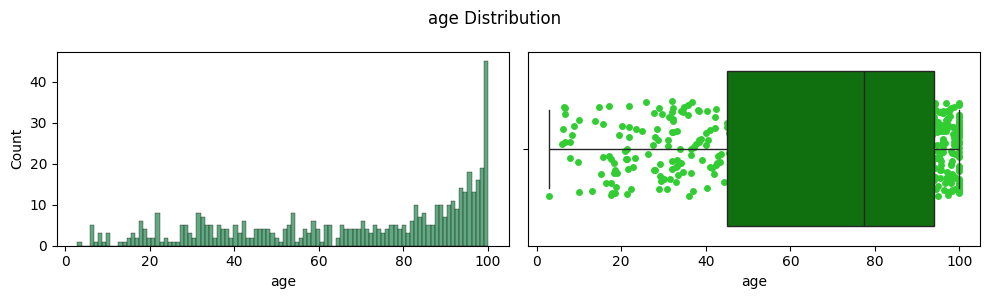

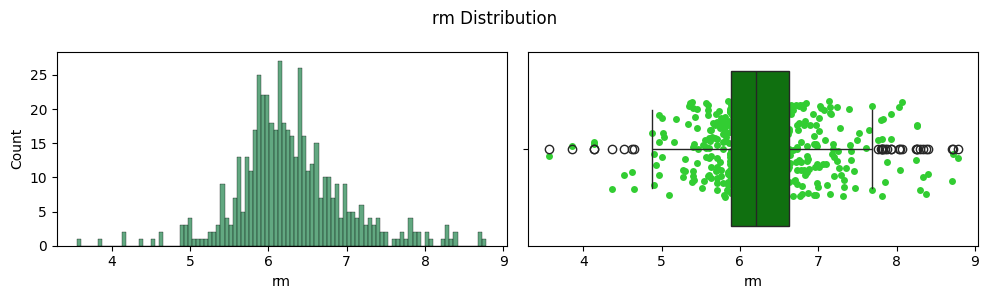

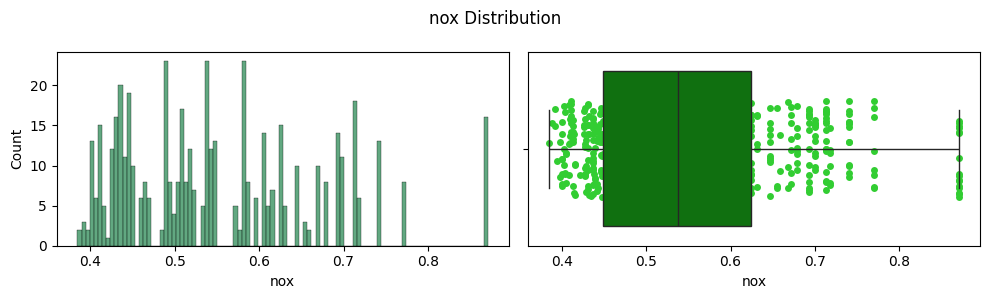

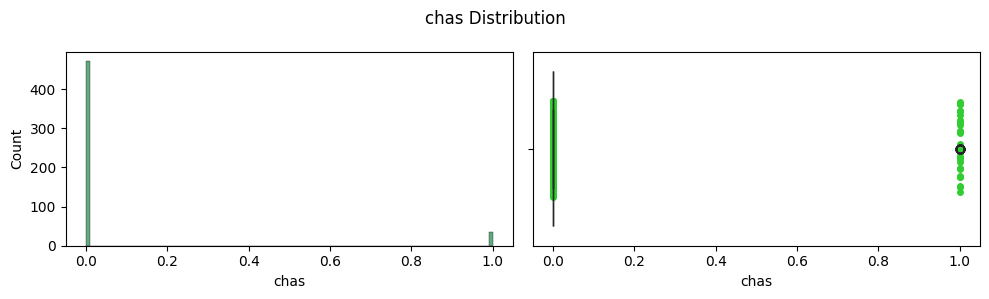

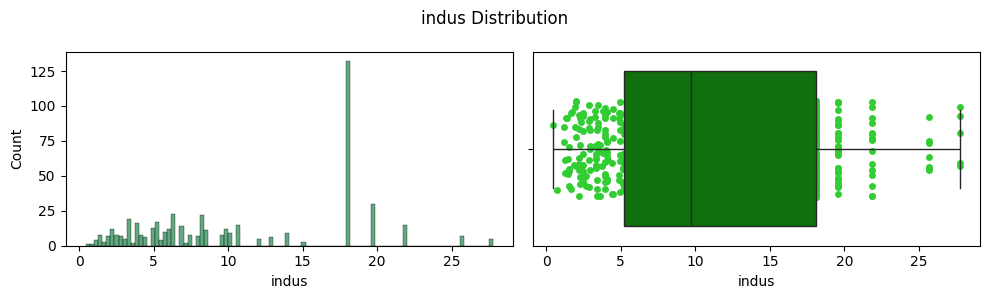

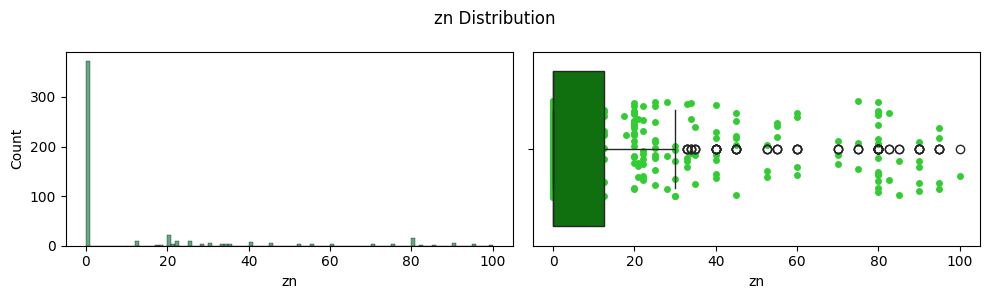

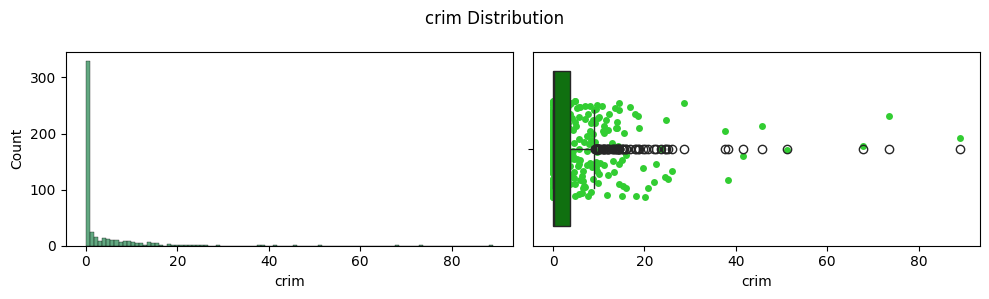

In [6]:
for c in data.columns[::-1]:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
    sns.histplot(data[c], bins=100, color="seagreen", ax=ax[0])
    sns.stripplot(data[c], orient="h", jitter=0.25, zorder=1,color="limegreen", ax=ax[1])
    sns.boxplot(data[c], color="green", orient="h", ax=ax[1])
    c = "Target" if c == "medv" else c
    fig.suptitle(f'{c} Distribution')
    fig.tight_layout()

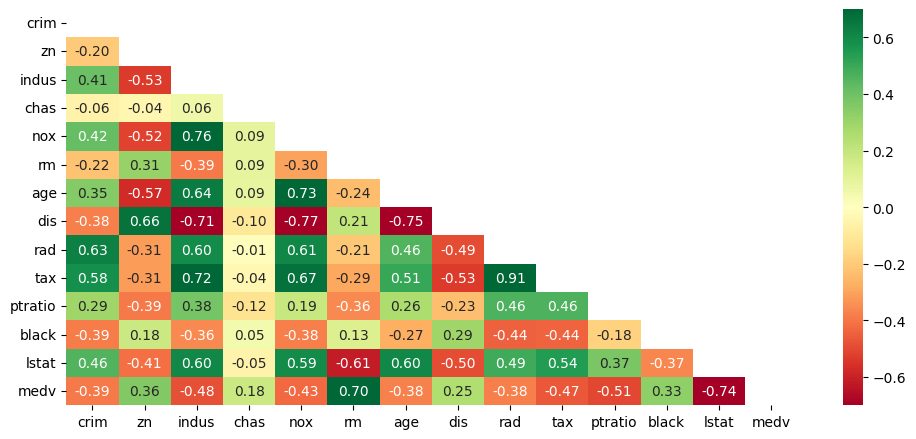

In [7]:
fig, ax = plt.subplots(figsize=(10, 4.5))
sns.heatmap(
    data.corr(), 
    annot=True, 
    cmap='RdYlGn', 
    center=0, 
    vmax=0.7, 
    vmin=-0.7, 
    fmt=".2f", 
    mask=np.triu(np.ones_like(data.corr(), dtype=bool)),
    ax=ax
)
fig.tight_layout()

## Modeling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('medv', axis=1), 
    data['medv'], 
    test_size=0.2
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
class NNRegressorEstimator(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        model, 
        loss="mse", 
        optimizer="adam", 
        lr=0.001, 
        epochs=100, 
        batch_size=64, 
        shuffle=True, 
        verbose=True, 
        validation_split=0.1,
        random_state=None
    ):
        """
        PyTorch neural network regressor with sklearn compatibility.
        
        Parameters
        ----------
        model : torch.nn.Module
            PyTorch model instance
        loss : str, default="mse"
            Loss function: "mse", "mae", "huber"
        optimizer : str, default="adam"
            Optimizer: "adam", "sgd", "rmsprop"
        lr : float, default=0.001
            Learning rate
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=64
            Batch size
        shuffle : bool, default=True
            Whether to shuffle training data
        verbose : bool, default=True
            Whether to print training progress
        validation_split : float, default=0.1
            Fraction of training data to use for validation
        random_state : int, default=None
            Random seed for reproducibility
        """
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.verbose = verbose
        self.validation_split = validation_split
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit the model to training data.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) Training data
        y : array-like of shape (n_samples,) Target values
            
        Returns
        -------
        self : object Fitted estimator
        """
        # Set random seeds for reproducibility
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)

        # instantiate loss and optimizer
        if self.loss == "mse":
            loss = nn.MSELoss()
        if self.optimizer == "adam":
            optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # split data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.validation_split, random_state=self.random_state)

        # tensorify data
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
        dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=self.batch_size, shuffle=self.shuffle)

        # train model
        self.model.train()
        train_losses, val_losses = [], []

        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                preds = self.model(batch_X)
                batch_loss = loss(preds, batch_y)
                batch_loss.backward()
                optimizer.step()

            with torch.no_grad():
                train_preds, val_preds = self.model(X_train), self.model(X_val)
                train_loss, val_loss = loss(train_preds, y_train).item(), loss(val_preds, y_val).item()
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            if self.verbose:
                print(f"Epoch: {epoch}/{self.epochs} - Train Loss {train_loss} - Val Loss: {val_loss}")
        
        self.train_losses_ = train_losses
        self.val_losses_ = val_losses
        self.is_fitted_ = True
        return self

    def predict(self, X):
        """
        Make predictions for X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)Input data
            
        Returns
        -------
        y : ndarray of shape (n_samples,) Predicted values
        """
        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            return self.model(X).detach().numpy().ravel()
        
    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        """
        params = {
            'model': self.model,
            'loss': self.loss,
            'optimizer': self.optimizer,
            'lr': self.lr,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'shuffle': self.shuffle,
            'verbose': self.verbose,
            'validation_split': self.validation_split,
            'random_state': self.random_state
        }
        return params
    
    def set_params(self, **parameters):
        """
        Set the parameters of this estimator.
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [34]:
class NNRegressor(nn.Module):
    def __init__(self, input_size, layers=[32, 32, 8], output_size=1):
        nn.Module.__init__(self)
        self.input_size = input_size
        self.layers = layers
        self.output_size = output_size
        for i in range(len(layers)):
            in_features = input_size if i == 0 else layers[i-1]
            out_features = layers[i]
            setattr(self, f"fc{i}", nn.Linear(in_features, out_features))
        self.final_linear = nn.Linear(layers[-1], output_size)
    
    def forward(self, x):
        for i in range(len(self.layers)):
            x = getattr(self, f"fc{i}")(x)
            x = nn.ReLU()(x)
        x = self.final_linear(x)
        return x
 

In [35]:
model = NNRegressor(input_size=X_train.shape[1], layers=[64, 32], output_size=1)
model_estimator = NNRegressorEstimator(model=model)

In [36]:
model_estimator.fit(X_train, y_train)

Epoch: 0/100 - Train Loss 600.9989624023438 - Val Loss: 579.5227661132812
Epoch: 1/100 - Train Loss 592.2291870117188 - Val Loss: 570.442138671875
Epoch: 2/100 - Train Loss 581.9487915039062 - Val Loss: 559.968017578125
Epoch: 3/100 - Train Loss 569.0875854492188 - Val Loss: 546.9616088867188
Epoch: 4/100 - Train Loss 552.8058471679688 - Val Loss: 530.4556274414062
Epoch: 5/100 - Train Loss 532.376708984375 - Val Loss: 509.896728515625
Epoch: 6/100 - Train Loss 507.33978271484375 - Val Loss: 484.69342041015625
Epoch: 7/100 - Train Loss 477.187744140625 - Val Loss: 454.3160400390625
Epoch: 8/100 - Train Loss 441.8387145996094 - Val Loss: 418.8397521972656
Epoch: 9/100 - Train Loss 401.1041564941406 - Val Loss: 377.9836730957031
Epoch: 10/100 - Train Loss 355.9031982421875 - Val Loss: 332.6385803222656
Epoch: 11/100 - Train Loss 307.3212890625 - Val Loss: 283.8106384277344
Epoch: 12/100 - Train Loss 258.9551696777344 - Val Loss: 235.40560913085938
Epoch: 13/100 - Train Loss 212.585784912

,model,"NNRegressor( ..., bias=True) )"
,loss,'mse'
,optimizer,'adam'
,lr,0.001
,epochs,100
,batch_size,64
,shuffle,True
,verbose,True
,validation_split,0.1
,random_state,None


In [37]:
model_estimator.predict(X_test).shape

(102,)

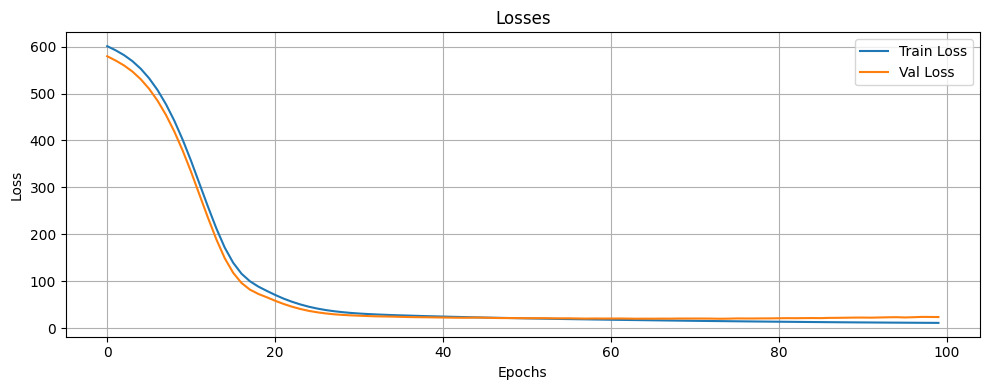

In [39]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")
    ax.set_title("Losses")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()

plot_losses(model_estimator.train_losses_, model_estimator.val_losses_)